# Plot leading and subleading leptonJet pair deltaPhi for mXX-100_mA-0p25_lxy-300 signals.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor

In [5]:
import json
selected = 'mXX-100_mA-0p25_lxy-300'
datasets = {selected: json.load(open('Samples/signal_4mu.json'))[selected]}

In [3]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "signal")
        dphi_axis = hist.Bin("dphi", "$\Delta\Phi$(lead, sublead) leptonJets", 50, 0, 3.142)
        
        self._accumulator = processor.dict_accumulator({
            'dphi': hist.Hist("norm. #counts/$\pi$/50", dataset_axis, dphi_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size!=0:
            leadingLjPair = leptonjetpair[sumpt.argmax()]
            dphi_ = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))
            
            output['dphi'].fill(dataset=dataset, dphi=dphi_.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [8]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=6, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 5/5 [00:02<00:00,  2.49items/s]


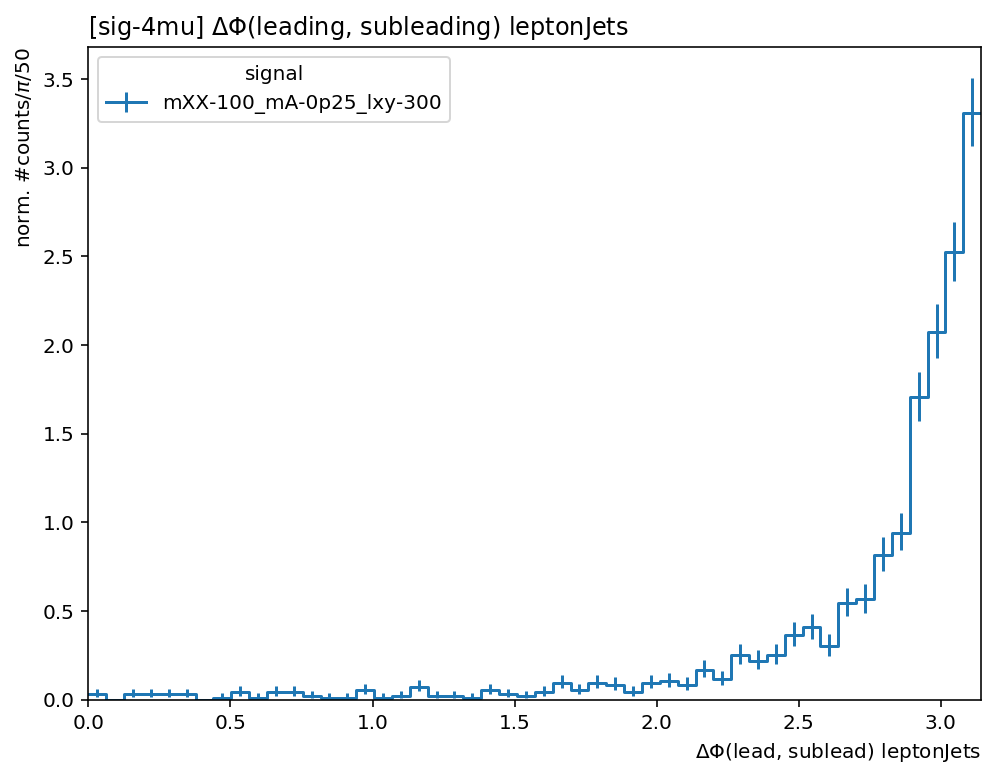

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['dphi'], ax=ax, overlay='dataset', density=True)

ax.set_title('[sig-4mu] $\Delta\Phi$(leading, subleading) leptonJets', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

---